In [15]:
import nbsetup

import numpy as np
from simulations.daisy_world.model import DaisyWorld, POP_DEFAULT

In [16]:
# Netlogo sim http://www.netlogoweb.org/launch#http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Biology/Daisyworld.nlogo
# Calcs http://gingerbooth.com/flash/daisyball/daisyworldmath.html
# 

In [99]:
from helpers.ergodic import ErgodicEnsemble

class BasicDaisyWorldTimeSeries:
    def __init__(self):
        self.observations = []

    def create(self, ensembles=20, *args, **kwargs):
        """ Sets up all the worlds or can just assign worlds """
        worlds = []
        for e in range(ensembles):
            worlds.append(DaisyWorld(*args, **kwargs))
        self.worlds = worlds
    
    def simulate(self, distance=100):
        """ Runs the simulation for all worlds for `distance` steps """
        timestep_obs = []
        
        for d in range(distance):
            ensemble_obs = []
            for w in self.worlds:
                w.step()
                ensemble_obs.append(w.grid_as_numpy().flatten())
            timestep_obs.append(ensemble_obs)
        
        self.observations += timestep_obs
    
    def analyse(self):
        """ Creates ErgodicEnsembles for each timestep """
        # assume the same bins for all ensembles (which should be true for DaisyWorld)
        bins = self.worlds[0].bins
        
        # data for each plot line
        ees = []
        entropies = []
        complexities = []
        ergodics = []
        
        # stored across all steps
        for timestep_obs in self.observations:
            ee = ErgodicEnsemble(timestep_obs, bins)
            ees.append(ee)
            entropies.append(ee.entropies)
            complexities.append(ee.complexity)
            ergodics.append(ee.ergodic)
        
        # numpy'd
        self.ees = ees
        self.entropies = np.array(entropies)
        self.complexities = np.array(complexities)
        self.ergodics = np.array(ergodics)
        self.timesteps = range(len(self.observations))
    
    def stats(self):
        msg = ""
        msg += "%.1f%% maximum " % (self.complexities.max()*100)
        msg += "%.1f%% mean " % (self.complexities.mean()*100)
        trend = int(len(self.timesteps)*0.1)
        msg += "%.1f%% trending " % (self.complexities[-trend:].mean()*100)
        print(msg)
        return msg
    
    def plot(self):
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
        
        # ergodics
        for e in np.stack(self.entropies, axis=1):
            sns.lineplot(x=self.timesteps, y=e, alpha=0.15, ax=axes[0])
        means = self.entropies.mean(axis=1)
        sns.lineplot(x=self.timesteps, y=means, ax=axes[0], label="Ensemble Mean")
        g = sns.lineplot(x=self.timesteps, y=self.ergodics, ax=axes[0], label="Ergodic")
        g.set(ylim=(0,None))
        g.set_xlabel("Timesteps")
        g.set_ylabel("Entropy of system")
        g.set_title("Evolution of entropies")
        
        # complexities
        g = sns.lineplot(x=self.timesteps, y=self.complexities, ax=axes[1])
        g.set(ylim=(0,1))
        g.set_xlabel("Timesteps")
        g.set_ylabel("Ergodic Complexity of system")
        g.set_title("Evolution of ergodic complexity")
        

1.5% maximum 0.7% mean 1.3% trending 


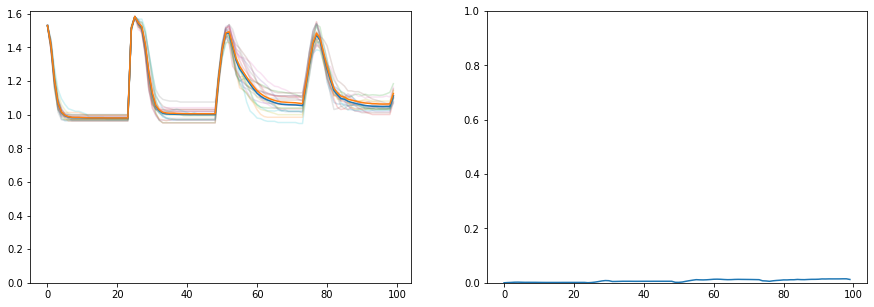

In [63]:
worlds = BasicDaisyWorldTimeSeries()
worlds.create(20, POP_DEFAULT, store=False)
worlds.simulate()
worlds.analyse()
worlds.stats()
worlds.plot()

2.2% maximum 1.0% mean 1.1% trending 


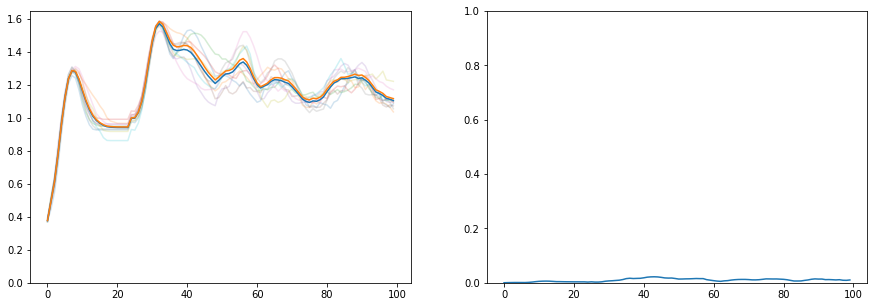

In [54]:

creations = []
ensembles = 10
for w in range(ensembles):
    creations.append(DaisyWorld({
    'white': {'albedo': 0.75, 'initial': 0.02},
    'black': {'albedo': 0.25, 'initial': 0.02},
    }, store=False))
worlds = BasicDaisyWorldTimeSeries()
worlds.worlds = creations
worlds.simulate()
worlds.analyse()
worlds.stats()
worlds.plot()

16.7% maximum 1.0% mean 0.3% trending 


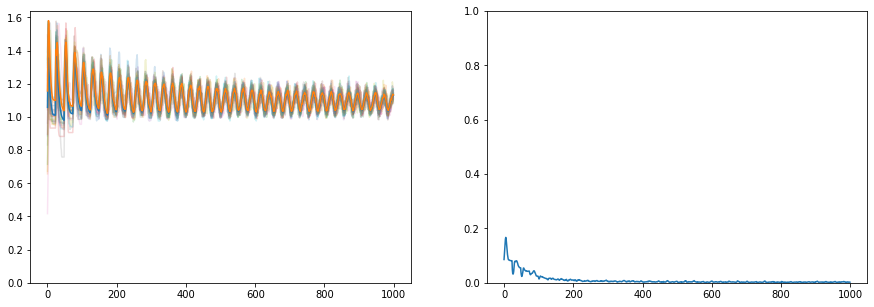

In [57]:
creations = []
ensembles = 20
for w in range(ensembles):
    creations.append(DaisyWorld({
    'white': {'albedo': 0.75, 'initial': np.random.random()*0.2},
    'black': {'albedo': 0.25, 'initial': np.random.random()*0.2},
    }, store=False))
worlds = BasicDaisyWorldTimeSeries()
worlds.worlds = creations
worlds.simulate(1000)
worlds.analyse()
worlds.stats()
worlds.plot()

18.3% maximum 15.3% mean 13.9% trending 


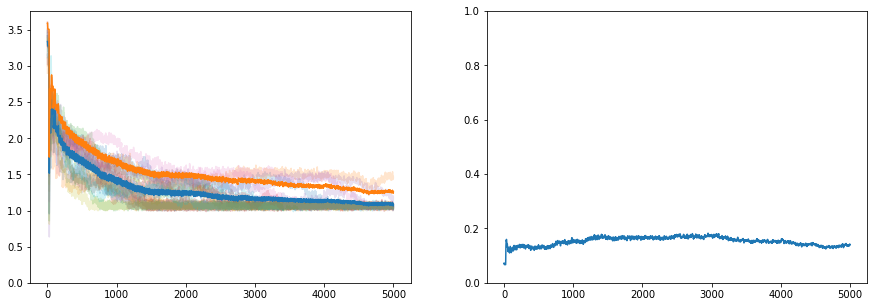

In [78]:
creations = []
ensembles = 20
for w in range(ensembles):
    creations.append(DaisyWorld({
    'white': {'albedo': 0.75, 'initial': np.random.random()*0.1},
    'white 2': {'albedo': 0.7, 'initial': np.random.random()*0.1},
    'white 3': {'albedo': 0.71, 'initial': np.random.random()*0.1},
    'white 4': {'albedo': 0.8, 'initial': np.random.random()*0.1},
    'white 5': {'albedo': 0.81, 'initial': np.random.random()*0.1},
    'white 6': {'albedo': 0.85, 'initial': np.random.random()*0.1},
    
    'black': {'albedo': 0.25, 'initial': np.random.random()*0.1},
    'black 2': {'albedo': 0.2, 'initial': np.random.random()*0.1},
    'black 3': {'albedo': 0.21, 'initial': np.random.random()*0.1},
    'black 4': {'albedo': 0.3, 'initial': np.random.random()*0.1},
    'black 5': {'albedo': 0.31, 'initial': np.random.random()*0.1},
    'black 6': {'albedo': 0.1, 'initial': np.random.random()*0.1},
    }, store=False))
worlds = BasicDaisyWorldTimeSeries()
worlds.worlds = creations
worlds.simulate(5000)
worlds.analyse()
worlds.stats()
worlds.plot()

In [97]:
def create_species(albedo, initial):
    return {
        'albedo': np.random.normal(albedo, 0.1),
        'initial': np.random.random()*0.1,
    }

def create_ecosystem(variations=3, variance=0.01):
    eco = {}
    for e in range(variations):
        eco["white %s" % e] = create_species(0.75, variance)
        eco["black %s" % e] = create_species(0.25, variance)
    return eco

69.6% maximum 56.3% mean 67.7% trending 


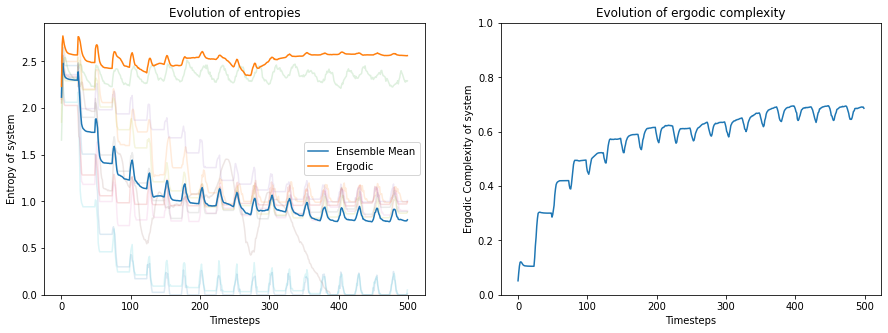

In [101]:
creations = []
ensembles = 10
timesteps = 500
for w in range(ensembles):
    creations.append(DaisyWorld(create_ecosystem(3), store=False))
worlds = BasicDaisyWorldTimeSeries()
worlds.worlds = creations
worlds.simulate(timesteps)
worlds.analyse()
worlds.stats()
worlds.plot()